# Analyze Tweets

In [1]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt

In [8]:
src = '../data/tweets'
hashtags = [
    'DauerstellenFürDaueraufgaben',
    'WissZeitVG',
    'FristIstFrust',
    '95vsWissZeitVG',
    'ACertainDegreeOfFlexibility',
    'IchBinHanna'
]

In [3]:
def get_tweet_frequency(src, filename, date_cutoff=pd.to_datetime('2017-07-01')):
    data = pd.read_csv(join(src, '{}.csv'.format(filename)), low_memory=False)
    print('{}: {} Tweets'.format(filename, len(data)))
    data['created_at'] = pd.to_datetime(data['created_at'])
    data['created_at_date'] = data['created_at'].dt.date
    data = data[data['created_at_date'] >= date_cutoff]
    
    frequency = data[['created_at_date', 'id']]\
        .groupby('created_at_date')\
        .agg('count')\
        .rename(columns={'id':'tweet_count'})
    
    return frequency

## Tweets

In [4]:
frequency = get_tweet_frequency(src, '95vsWissZeitVG')
frequency.loc[frequency['tweet_count'].idxmax()]

95vsWissZeitVG: 14706 Tweets


tweet_count    1317
Name: 2020-10-31, dtype: int64

In [5]:
frequency = get_tweet_frequency(src, 'IchBinHanna')
frequency.loc[frequency['tweet_count'].idxmax()]

IchBinHanna: 63771 Tweets


tweet_count    9908
Name: 2021-06-11, dtype: int64

In [6]:
frequency = get_tweet_frequency(src, 'ACertainDegreeOfFlexibility')
frequency.loc[frequency['tweet_count'].idxmax()]

ACertainDegreeOfFlexibility: 13172 Tweets


tweet_count    941
Name: 2020-12-10, dtype: int64

### Hashtag tweet frequency

WissZeitVG: 15077 Tweets
FristIstFrust: 16261 Tweets
95vsWissZeitVG: 14706 Tweets
ACertainDegreeOfFlexibility: 13172 Tweets
IchBinHanna: 63771 Tweets


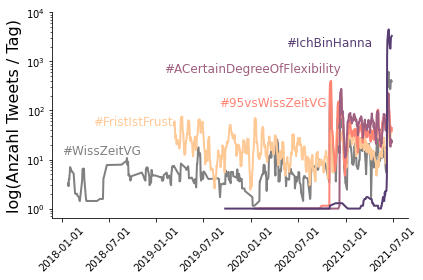

In [12]:
colors = ['#1c9099', 'grey', '#ffc996', '#ff8474', '#9f5f80', '#583d72' ]

fig, ax = plt.subplots()
for ht, color in zip(hashtags, colors):
    if ht == 'DauerstellenFürDaueraufgaben':
        continue
    frequency = get_tweet_frequency(src, ht)
    frequency_avg = frequency['tweet_count'].rolling(7).mean().dropna()
    ax.plot(frequency_avg.index, frequency_avg.values, color=color,
            label='#{}'.format(ht), linewidth=2)
    
ax.set_yscale('log')
#ax.set_xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2021-07-01'))
ax.set_ylim(ymax=1e4)
ax.set_xticks([pd.to_datetime(t) for t in ['2018-01-01', '2018-07-01',
            '2019-01-01', '2019-07-01','2020-01-01', '2020-07-01',
            '2021-01-01', '2021-07-01',]])
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('log(Anzahl Tweets / Tag)', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.text(pd.to_datetime('2018-06-20'), 1.2, '#DauerstellenfürDaueraufgaben', fontsize=12, color=colors[0])
ax.text(pd.to_datetime('2018-01-01'), 13, '#WissZeitVG', fontsize=12, color=colors[1])
ax.text(pd.to_datetime('2018-05-01'), 50, '#FristIstFrust', fontsize=12, color=colors[2])
ax.text(pd.to_datetime('2019-09-01'), 120, '#95vsWissZeitVG', fontsize=12, color=colors[3])
ax.text(pd.to_datetime('2019-02-01'), 600, '#ACertainDegreeOfFlexibility', fontsize=12, color=colors[4])
ax.text(pd.to_datetime('2020-05-15'), 2000, '#IchBinHanna', fontsize=12, color=colors[5])

#ax.text(pd.to_datetime('2018-01-01'), 1.8*1e3,'Tweets gesammelt\nab 2018-01-01.',
#       fontsize=10, color='grey')
#ax.text(pd.to_datetime('2018-01-01'), 1.9*1e2,'Anzahl gemittelt\nüber 7 Tage.',
#       fontsize=10, color='grey')

fig.tight_layout()
#plt.savefig('/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Data/Updates/tweet_frequency_ext.png', dpi=400)
plt.savefig('../plots/tweet_frequency.svg')

### Tweets with the video link

In [206]:
frequency = get_tweet_frequency(src, 'video_url')
frequency

video_url: 1473 Tweets


,tweet_count
created_at_date,
2021-06-09,28
2021-06-10,856
2021-06-11,488
2021-06-12,56
2021-06-13,13
2021-06-14,30


## Users

In [16]:
hashtags = [
    'WissZeitVG',
    'FristIstFrust',
    '95vsWissZeitVG',
    'ACertainDegreeOfFlexibility',
    'IchBinHanna'
]

### Unique Users

In [17]:
def get_N_authors(src, filename):
    data = pd.read_csv(join(src, '{}.csv'.format(filename)), low_memory=False)\
        .dropna(subset=['author_id'])
    data['author_id'] = data['author_id'].astype(int)
    N_authors = data['author_id'].unique()
    return len(N_authors)

In [18]:
N_authors = [get_N_authors(src, ht) for ht in hashtags]
N_authors = pd.DataFrame({'hashtag':['#{}'.format(h) for h in hashtags],
                          'N_authors':N_authors})\
    .sort_values(by='N_authors')

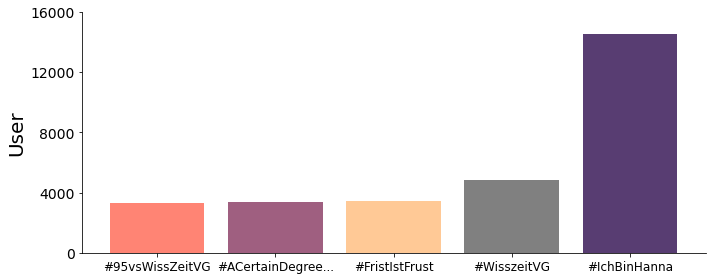

In [32]:
fig, ax = plt.subplots(figsize=(10, 4))
colors = ['#ff8474', '#9f5f80', '#ffc996', 'grey', '#583d72']
ax.bar(N_authors['hashtag'], N_authors['N_authors'], color=colors)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('User', fontsize=20)
ax.set_xticks(range(5))
ax.set_xticklabels(['#95vsWissZeitVG', '#ACertainDegree...', '#FristIstFrust',
                    '#WisszeitVG', '#IchBinHanna'])
ax.set_ylim(0, 16000)
ax.set_yticks(range(0, 16001, 4000))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=14)
fig.tight_layout()
plt.savefig('../plots/unique_users.png', dpi=300)
plt.savefig('../plots/unique_users.svg')

### New users for #IchBinHanna

In [26]:
users_95WissZeitVG = set(pd.read_csv(join(src, '{}.csv'.format('95vsWissZeitVG')), 
                        low_memory=False).dropna(subset=['author_id'])['author_id'].unique())
users_FristIstFrust = set(pd.read_csv(join(src, '{}.csv'.format('FristIstFrust')), 
                        low_memory=False).dropna(subset=['author_id'])['author_id'].unique())
users_WissZeitVG = set(pd.read_csv(join(src, '{}.csv'.format('WissZeitVG')), 
                        low_memory=False).dropna(subset=['author_id'])['author_id'].unique())
users_ACertainDegree = set(pd.read_csv(join(src, '{}.csv'.format('ACertainDegreeOfFlexibility')), 
                        low_memory=False).dropna(subset=['author_id'])['author_id'].unique())
users_IchBinHanna = set(pd.read_csv(join(src, '{}.csv'.format('IchBinHanna')), 
                        low_memory=False).dropna(subset=['author_id'])['author_id'].unique())

In [27]:
old_users = users_95WissZeitVG.union(users_FristIstFrust).union(users_WissZeitVG).union(users_ACertainDegree)

In [28]:
shared_users = users_IchBinHanna.intersection(old_users)
new_users = users_IchBinHanna - old_users

In [29]:
print('The #IchBinHanna campaign engaged {} new users'.format(len(new_users)))

The #IchBinHanna campaign engaged 9366 new users


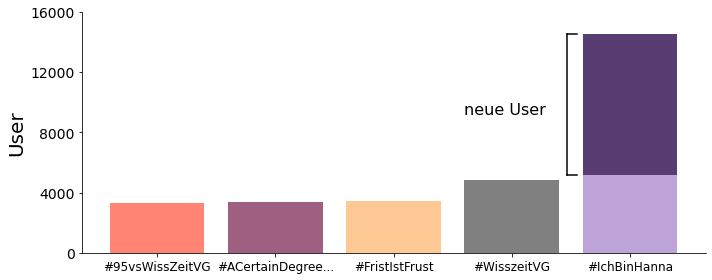

In [43]:
fig, ax = plt.subplots(figsize=(10, 4))
colors_mod = ['#ff8474', '#9f5f80', '#ffc996', 'grey', '#BEA3D8']
N_old_users = [0, 0, 0, 0, len(shared_users)]

N_authors['new_users'] = list(N_authors.iloc[0:4]['N_authors']) + \
        [len(users_IchBinHanna) - len(shared_users)]
ax.bar(N_authors['hashtag'], N_old_users, color=colors_mod)
ax.bar(N_authors['hashtag'], N_authors['new_users'], 
       bottom=N_old_users, color=colors)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('User', fontsize=20)
ax.set_xticks(range(5))
ax.set_xticklabels(['#95vsWissZeitVG', '#ACertainDegree...', '#FristIstFrust',
                    '#WisszeitVG', '#IchBinHanna'])
ax.set_ylim(0, 16000)
ax.set_yticks(range(0, 16001, 4000))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=14)

ax.plot([3.47, 3.55], [len(shared_users), len(shared_users)], color='k')
ax.plot([3.47, 3.55], [len(users_IchBinHanna), len(users_IchBinHanna)], color='k')
ax.plot([3.47, 3.47], [len(shared_users), len(users_IchBinHanna)], color='k')
ax.text(2.6, 9200, 'neue User', fontsize=16)
fig.tight_layout()
plt.savefig('../plots/unique_users_new_users.png', dpi=300)
plt.savefig('../plots/unique_users_new_users.svg')

## URLs

Extract all URLs mentioned in Tweets. Work in progress

In [217]:
data = pd.read_csv(join(src, 'IchBinHanna.csv'), low_memory=False)

In [99]:
raw_urls = data['entities.urls'].dropna()
urls = []
for row in raw_urls:
    for entry in row:
        urls.append(entry['url'])

TypeError: string indices must be integers

In [101]:
row

'[{"start": 151, "end": 174, "url": "https://t.co/0xVTlaqxO5", "expanded_url": "https://www.bmbf.de/de/media-video-16944.html", "display_url": "bmbf.de/de/media-video\\u2026"}]'

In [104]:
entries = row.split(',')

In [105]:
entries.replace(' "url": "', '')

AttributeError: 'list' object has no attribute 'replace'

In [128]:
row = raw_urls.iloc[1]
row = row.replace('[', '').replace(']', '')
entries = row.split('},')
entries = [e.replace(' {', '') for e in entries]
entries = [{e.split(': ')[0].replace('"', ''):e.split(': ')[1].replace('"', '')}\
           for e in entries]

In [130]:
row

'{"start": 251, "end": 274, "url": "https://t.co/UczaTWX62M", "expanded_url": "https://www.bmbf.de/de/media-video-16944.html", "display_url": "bmbf.de/de/media-video\\u2026", "images": {"url": "https://pbs.twimg.com/news_img/1402590778543722496/xFefjQWc?format=jpg&name=orig", "width": 684, "height": 385}, {"url": "https://pbs.twimg.com/news_img/1402590778543722496/xFefjQWc?format=jpg&name=150x150", "width": 150, "height": 150}, "status": 200, "title": "Wozu dient das Wissenschaftszeitvertragsgesetz? - BMBF", "description": "Erkl\\u00e4rfilm zum Wissenschaftszeitvertragsgesetz", "unwound_url": "https://www.bmbf.de/de/media-video-16944.html"}'

In [ ]:
def convert_to_list:
    row = row.replace('[', '').replace(']', '')